In [1]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())
print(torch.version.cuda)
print('Location:', torch.__file__) # /home/emre/.local/lib/python3.7/site-packages

1.12.0+cu102
True
10.2
Location: /home/emre/anaconda3/envs/emre_venv/lib/python3.9/site-packages/torch/__init__.py


/home/emre/anaconda3/envs/emre_venv/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from typing import Union, Tuple
from torch_geometric.typing import OptPairTensor, Adj, Size # Optional[Tensor], Union[Tensor, SparseTensor], Optional[Tuple[int, int]], all about data type

from torch import Tensor
from torch.nn import Linear
import torch.nn.functional as F
from torch_sparse import SparseTensor, matmul
from torch_geometric.nn.conv import MessagePassing

In [3]:
import warnings
warnings.filterwarnings("ignore")
from joblib import Parallel, delayed

from sklearn.preprocessing import StandardScaler, MinMaxScaler

import torch.nn as nn
import torch.nn.functional as F
import torch_geometric.nn as gnn
from torchsummary import summary
import torchvision
from torch_geometric.nn import MessagePassing
from torch_geometric.data import Dataset, Data, DataLoader
from torch_geometric.nn import global_mean_pool as gap, global_max_pool as gmp
from torch_geometric.utils import softmax

In [4]:
import pickle
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output
!CUDA_LAUNCH_BLOCKING=1
torch.cuda.set_device(1)
print('Num GPU:', torch.cuda.device_count())
print('Current device:', torch.cuda.current_device())
print('Device name:', torch.cuda.get_device_name())

Num GPU: 3
Current device: 1
Device name: TITAN V


In [5]:
def load_pkl(filename):
    with open(filename, 'rb') as input:
        data = pickle.load(input)
    return data

In [6]:
[train_images, train_labels, train_files,
 test_images, test_labels, test_files] = load_pkl('../datasets/imit_ASL_10_mDreal_224x224.pkl')
train_labels = np.argmax(train_labels, -1)
test_labels = np.argmax(test_labels, -1)

print(train_images.shape)
print(train_labels.shape)
print(test_images.shape)
print(test_labels.shape)

(1539, 3, 224, 224)
(1539,)
(385, 3, 224, 224)
(385,)


In [7]:
[train_images2, train_labels2, train_files2,
 test_images2, test_labels2, test_files2] = load_pkl('../datasets/imit_ASL_10_mDsim_224x224.pkl')
train_labels2 = np.argmax(train_labels2, -1)
test_labels2 = np.argmax(test_labels2, -1)

print(train_images2.shape)
print(train_labels2.shape)
print(test_images2.shape)
print(test_labels2.shape)

(1539, 3, 224, 224)
(1539,)
(385, 3, 224, 224)
(385,)


# Jovian

In [8]:
import torchvision.transforms as transforms
import torchvision.models as models
from PIL import Image
from IPython.display import clear_output

import copy

In [9]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = 'cpu'

In [10]:
imsize = 512 if torch.cuda.is_available() else 128  # use small size if no gpu

loader = transforms.Compose([
    transforms.Resize((imsize, imsize)),  # scale imported image
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

In [11]:
def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    if title is not None:
        plt.title(title)
    plt.pause(0.001) # pause a bit so that plots are updated

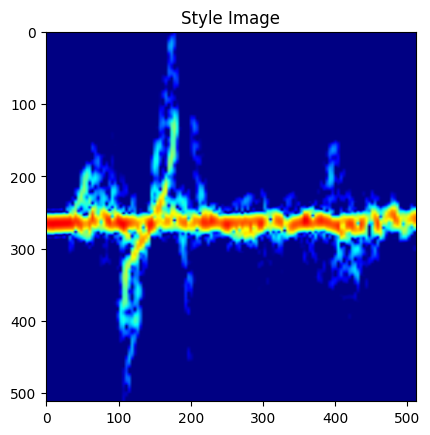

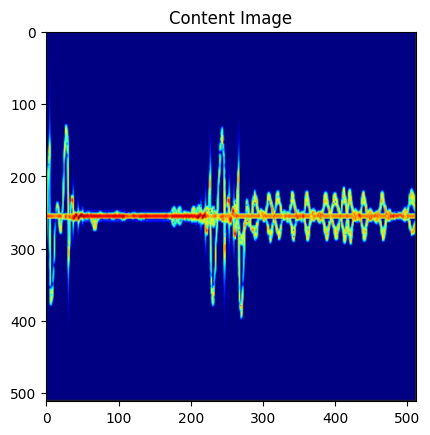

In [12]:
unloader = transforms.ToPILImage()  # reconvert into PIL image
sim_path = '/mnt/HDD04/ASL_10_imit/outputs/microDoppler_sim/'
real_path = '/mnt/HDD04/ASL_10_imit/outputs/microDoppler_real/cut/'
plt.ion()
idx = 0

plt.figure()
# style_img = image_loader(train_images[idx].transpose(1, 2, 0))
style_img = image_loader(real_path + train_files[idx] + '.png')
imshow(style_img, title='Style Image')

plt.figure()
content_img = image_loader(sim_path + train_files[idx] + '.png') 
imshow(content_img, title='Content Image')

assert style_img.size() == content_img.size(), \
    "we need to import style and content images of the same size"

In [13]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input


In [14]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)

In [15]:
class StyleLoss(nn.Module):

    def __init__(self, target_feature):
        super(StyleLoss, self).__init__()
        self.target = gram_matrix(target_feature).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = F.mse_loss(G, self.target)
        return input


In [16]:
cnn_normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
cnn_normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

# create a module to normalize input image so we can easily put it in a
# nn.Sequential
class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [17]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature = model(style_img).detach()
            style_loss = StyleLoss(target_feature)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses


In [18]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = torch.optim.LBFGS([input_img.requires_grad_()])
    return optimizer


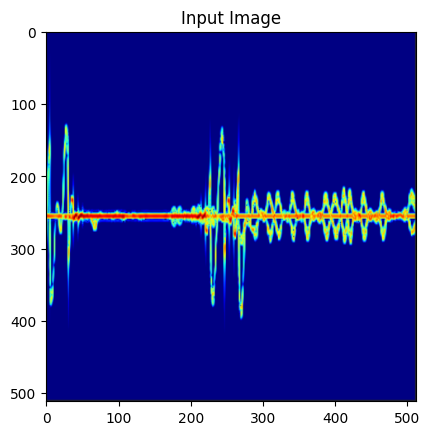

In [19]:
input_img = content_img.clone()
# if you want to use white noise instead uncomment the below line:
# input_img = torch.randn(content_img.data.size(), device=device)

# add the original input image to the figure:
plt.figure()
imshow(input_img, title='Input Image')

In [28]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=100,
                       style_weight=20000000000, content_weight=0.001): # sw = 1000000, cw = 1
    """Run the style transfer."""
    print('Building the style transfer model..')
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    loss = 0
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
#             input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img


Building the style transfer model..
Optimizing..
run [50]:
Style Loss : 12.897019 Content Loss: 0.000145

run [100]:
Style Loss : 2.886863 Content Loss: 0.000145



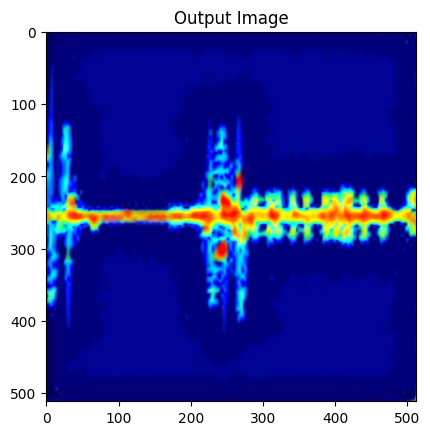

In [29]:
cnn = models.vgg19_bn(pretrained=True).features.to(device).eval()
output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)

plt.figure()
imshow(output, title='Output Image')

# sphinx_gallery_thumbnail_number = 4
plt.ioff()
plt.show()

In [30]:
savepath = sim_path.replace('sim', 'realism')
print(savepath)
cnn = models.vgg19_bn(pretrained=True).features.to(device).eval()
for i, f in enumerate(train_files):
    style_img = image_loader(real_path + f + '.png')
    content_img = image_loader(sim_path + f + '.png')
    input_img = content_img.clone()
    save_name = savepath + f + '.png'
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
    image = output.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    image.save(save_name)
    clear_output(wait=True)
    print('Training files: ', i+1, '/', len(train_files))

Training files:  1539 / 1539


In [31]:
for i, f in enumerate(test_files):
    style_img = image_loader(real_path + f + '.png')
    content_img = image_loader(sim_path + f + '.png')
    input_img = content_img.clone()
    save_name = savepath + f + '.png'
    output = run_style_transfer(cnn, cnn_normalization_mean, cnn_normalization_std,
                            content_img, style_img, input_img)
    image = output.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    image.save(save_name)
    clear_output(wait=True)
    print('Testing files: ', i+1, '/', len(test_files))

Testing files:  385 / 385
